<a href="https://colab.research.google.com/github/sujitojha1/EVA8/blob/main/Session8/EVA8_S8_CIFAR10_resnet18_OneCyclePolicy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement EVA 8, Session8 : CIFAR 10


## 1. Loading Module and Models 

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Future print function
from __future__ import print_function

# Load modules/models from EVA course
!rm -rf models
!git clone https://github.com/sujitojha1/pytorch-eva8 -q --quiet
!mv pytorch-eva8/* .
print("Loaded EVA8 Modules and Models")

!rm -rf pytorch-eva8

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet

!pip install torch_lr_finder -q --quiet

# For inline matplotlib plotting
%matplotlib inline

Loaded EVA8 Modules and Models
  Preparing metadata (setup.py) ... done



## 2. Loading train and test data with transforms and loader functions

In [ ]:
from utils import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

CUDA availability ? True


/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


## 3. Exploratory Data Analysis

### 3.1 Summary Statistics

In [ ]:
cifar10.data_summary_stats()
#print(vars(train))

Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


### 3.2 Plotting sample images

Files already downloaded and verified


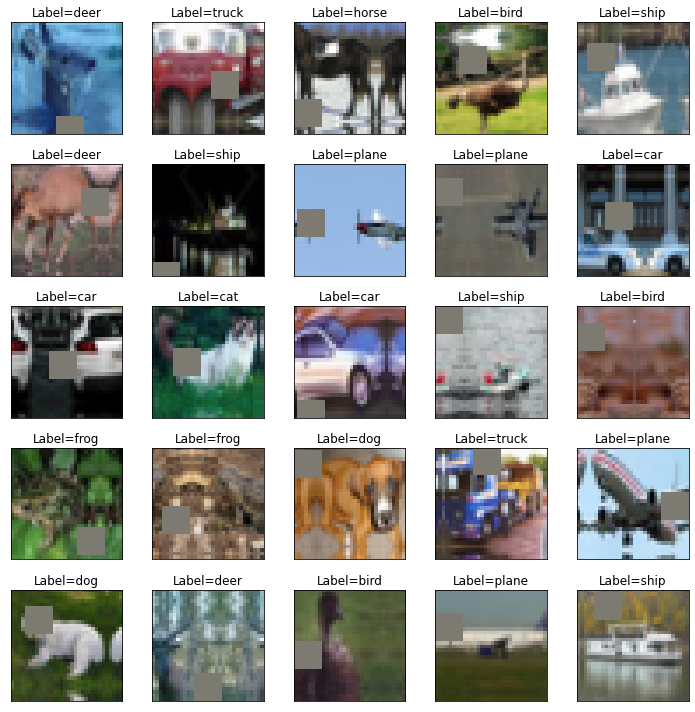

In [ ]:
cifar10.sample_pictures(train_flag=True)

# The Model

In [ ]:
from models.custom_resnet import *
import torch

# Loading ResNet18 Model
net = CustomResNet()

# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net = net.to(device)

cuda


# Model Summary

In [ ]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
         ResBlock-12          [-1, 128, 16, 16]               0
    

## Find the LR for One Cycle Learning Rate

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.66E-01


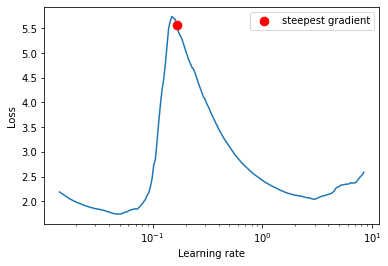

(<matplotlib.axes._subplots.AxesSubplot at 0x7f51a9f5ed30>,
 0.16638168860761288)

In [ ]:
import copy
from torch_lr_finder import LRFinder
import torch.nn as nn
import numpy as np

net_exp = copy.deepcopy(net)
optimizer = torch.optim.SGD(net_exp.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(net_exp, optimizer, criterion, device=device)
lr_finder.range_test(trainloader, end_lr=10, num_iter=200)
lr_finder.plot()

In [ ]:
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

Max LR is 0.0476861169771447


# Training and Testing

In [ ]:
# Load train and test model
from main import fit_model

optimizer = torch.optim.SGD(net.parameters(), lr=0.3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=0.3,
                                                steps_per_epoch=len(trainloader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=25,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
net, history = fit_model(
    net=net, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=trainloader, test_loader=testloader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.012)


Batch_id=97 Loss=1.71970 Accuracy=40.38%: 100%|██████████| 98/98 [00:33<00:00,  2.96it/s]



Test set: Average loss: 1.8064, Accuracy: 4094/10000 (40.94%)

EPOCH: 2 (LR: 0.07212782275244993)


Batch_id=97 Loss=1.44903 Accuracy=52.44%: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]



Test set: Average loss: 1.8969, Accuracy: 4902/10000 (49.02%)

EPOCH: 3 (LR: 0.13225564550489985)


Batch_id=97 Loss=1.05255 Accuracy=63.73%: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.9934, Accuracy: 6676/10000 (66.76%)

EPOCH: 4 (LR: 0.19238346825734978)


Batch_id=97 Loss=0.90118 Accuracy=68.84%: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]



Test set: Average loss: 0.8311, Accuracy: 7241/10000 (72.41%)

EPOCH: 5 (LR: 0.2525112910097997)


Batch_id=97 Loss=0.75395 Accuracy=73.94%: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]



Test set: Average loss: 0.6863, Accuracy: 7645/10000 (76.45%)

EPOCH: 6 (LR: 0.2967181887755102)


Batch_id=97 Loss=0.67083 Accuracy=76.71%: 100%|██████████| 98/98 [00:28<00:00,  3.41it/s]



Test set: Average loss: 1.0038, Accuracy: 7026/10000 (70.26%)

EPOCH: 7 (LR: 0.2811056887755102)


Batch_id=97 Loss=0.60609 Accuracy=78.89%: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]



Test set: Average loss: 0.9410, Accuracy: 7269/10000 (72.69%)

EPOCH: 8 (LR: 0.2654931887755102)


Batch_id=97 Loss=0.54182 Accuracy=80.99%: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]



Test set: Average loss: 0.5328, Accuracy: 8245/10000 (82.45%)

EPOCH: 9 (LR: 0.2498806887755102)


Batch_id=97 Loss=0.49663 Accuracy=82.84%: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]



Test set: Average loss: 0.5330, Accuracy: 8241/10000 (82.41%)

EPOCH: 10 (LR: 0.2342681887755102)


Batch_id=97 Loss=0.45997 Accuracy=83.99%: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.5159, Accuracy: 8373/10000 (83.73%)

EPOCH: 11 (LR: 0.21865568877551023)


Batch_id=97 Loss=0.42121 Accuracy=85.49%: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.4307, Accuracy: 8607/10000 (86.07%)

EPOCH: 12 (LR: 0.2030431887755102)


Batch_id=97 Loss=0.38851 Accuracy=86.61%: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]



Test set: Average loss: 0.4712, Accuracy: 8478/10000 (84.78%)

EPOCH: 13 (LR: 0.18743068877551022)


Batch_id=97 Loss=0.36596 Accuracy=87.25%: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]



Test set: Average loss: 0.3970, Accuracy: 8637/10000 (86.37%)

EPOCH: 14 (LR: 0.17181818877551022)


Batch_id=97 Loss=0.35149 Accuracy=87.75%: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]



Test set: Average loss: 0.3768, Accuracy: 8800/10000 (88.00%)

EPOCH: 15 (LR: 0.15620568877551022)


Batch_id=97 Loss=0.32134 Accuracy=88.86%: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]



Test set: Average loss: 0.3528, Accuracy: 8847/10000 (88.47%)

EPOCH: 16 (LR: 0.14059318877551022)


Batch_id=97 Loss=0.30708 Accuracy=89.22%: 100%|██████████| 98/98 [00:27<00:00,  3.50it/s]



Test set: Average loss: 0.3626, Accuracy: 8791/10000 (87.91%)

EPOCH: 17 (LR: 0.12498068877551019)


Batch_id=97 Loss=0.27827 Accuracy=90.25%: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]



Test set: Average loss: 0.3779, Accuracy: 8843/10000 (88.43%)

EPOCH: 18 (LR: 0.10936818877551022)


Batch_id=97 Loss=0.25951 Accuracy=90.91%: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]



Test set: Average loss: 0.3818, Accuracy: 8842/10000 (88.42%)

EPOCH: 19 (LR: 0.09375568877551022)


Batch_id=97 Loss=0.24169 Accuracy=91.50%: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]



Test set: Average loss: 0.3475, Accuracy: 8923/10000 (89.23%)

EPOCH: 20 (LR: 0.07814318877551021)


Batch_id=97 Loss=0.22621 Accuracy=91.98%: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]



Test set: Average loss: 0.3357, Accuracy: 8964/10000 (89.64%)

EPOCH: 21 (LR: 0.06253068877551024)


Batch_id=97 Loss=0.20567 Accuracy=92.77%: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]



Test set: Average loss: 0.3099, Accuracy: 9050/10000 (90.50%)

EPOCH: 22 (LR: 0.04691818877551024)


Batch_id=97 Loss=0.18309 Accuracy=93.53%: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.2947, Accuracy: 9096/10000 (90.96%)

EPOCH: 23 (LR: 0.03130568877551021)


Batch_id=97 Loss=0.16448 Accuracy=94.26%: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.2864, Accuracy: 9132/10000 (91.32%)

EPOCH: 24 (LR: 0.015693188775510236)


Batch_id=97 Loss=0.15074 Accuracy=94.75%: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]



Test set: Average loss: 0.2826, Accuracy: 9166/10000 (91.66%)



# Plotting Train & Test Accuracy/Losses

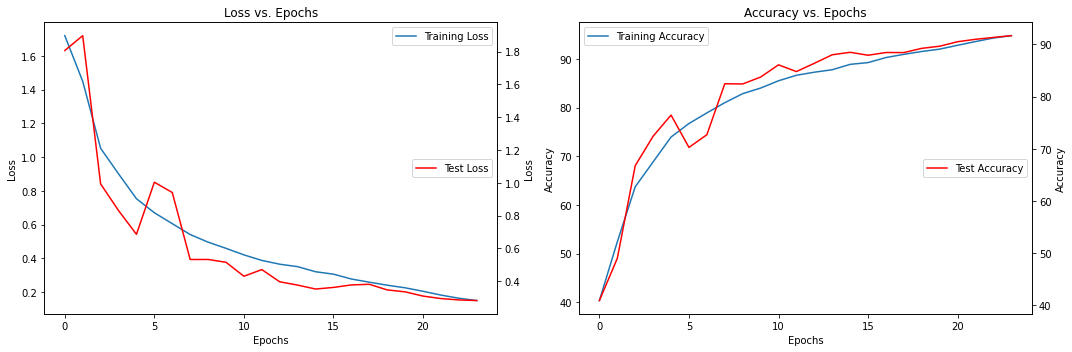

In [ ]:
from utils import plot_loss_accuracy_graph_OneCLR
plot_loss_accuracy_graph_OneCLR(*history[0:4])

# Evaluating test Accuracy over different classes 

In [ ]:
def calClassAccuracy(net, dataloader, classes, device):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images,labels = images.to(device),labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
#from utils import calAccuracy
calClassAccuracy(net, testloader, classes, device)

Accuracy of plane : 100 %
Accuracy of   car : 88 %
Accuracy of  bird : 85 %
Accuracy of   cat : 100 %
Accuracy of  deer : 100 %
Accuracy of   dog : 87 %
Accuracy of  frog : 100 %
Accuracy of horse : 100 %
Accuracy of  ship : 100 %
Accuracy of truck : 100 %


## Misclassified Images

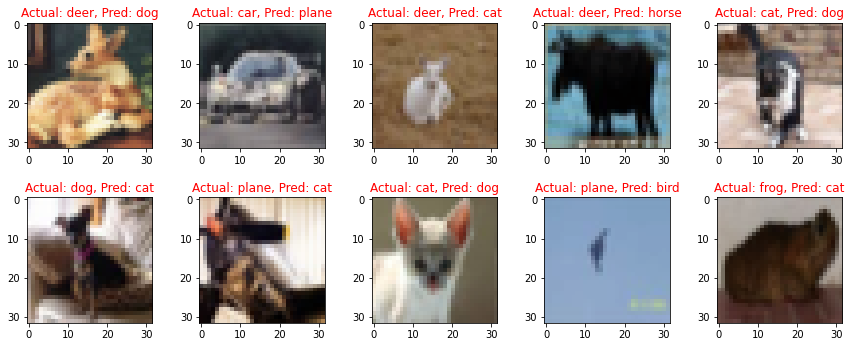

In [ ]:
from utils import plot_misclassified_images
plot_misclassified_images(net, testloader, classes, device)

## GradCAM images

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


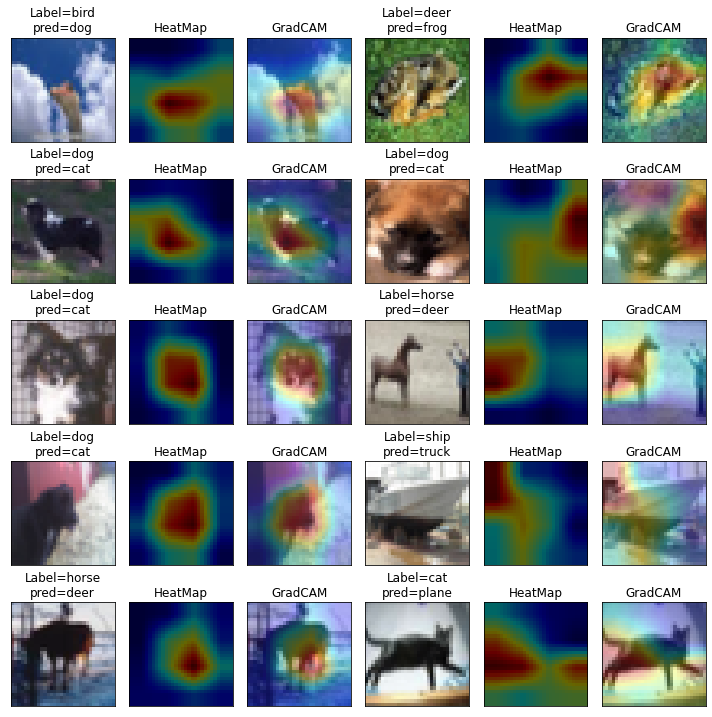

In [ ]:
from utils import plotGradCAM
# initialize a model, model_dict and gradcam
plotGradCAM(net, testloader, classes, device, layer_name='layer3')